# flax: Training Neural Networks for Classification and Dimensionality Reduction

This notebook demonstrates example neural network setups for **image classification** and **dimensionality reduction** tasks using `flax` (a wrapper for `jax`).

The examples serve as complement and comparison for exploring neural networks with the `edu.yaprnn` app.

Loading MNIST images from E:\edu.yaprnn\src\main\resources\digits.idx3-ubyte


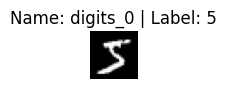

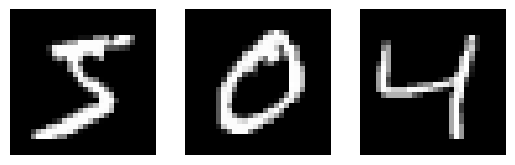

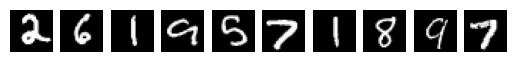

(36000, 784) (36000, 10) (36000,) (12000, 784) (12000, 10) (12000,)
(48000, 784) (48000, 10) (48000,) (12000, 784) (12000, 10) (12000,)
(48000, 784) (48000, 10) (48000,) (12000, 784) (12000, 10) (12000,)


In [1]:
from sklearn.model_selection import train_test_split

import mnist_utils
import model_utils

mnist_images, image_size, X, random_x_indices, random_feature_indices, y, labels = mnist_utils.from_mnist_images()

digits_train_32k_test_12k = train_test_split(X, y, labels, train_size=0.6, test_size=0.2, random_state=model_utils.SEED)
digits_images_from_labels = train_test_split(X, y, labels, train_size=0.8, test_size=0.2, random_state=model_utils.SEED)
digits_input_reconstruction = train_test_split(X, y, labels, train_size=0.8, test_size=0.2,
                                               random_state=model_utils.SEED)

mnist_utils.from_dataset(digits_train_32k_test_12k, explain=True)
mnist_utils.from_dataset(digits_images_from_labels, explain=True)
mnist_utils.from_dataset(digits_input_reconstruction, explain=True)

None

In [2]:
from flax import nnx
from tqdm.auto import trange
import flax.typing as ft
import jax
import jax.numpy as jnp
import jax.typing as jt
import numpy as np
import optax
import typing as tp


def count_parameters(_model):
    params = nnx.state(_model, nnx.Param)
    return sum(np.prod(x.shape) for x in jax.tree.leaves(params))


class LinearAndGeluBlock(nnx.Module):
    def __init__(self, in_features: int, out_features: int, rngs: nnx.Rngs):
        self.linear = nnx.Linear(in_features, out_features, rngs=rngs, kernel_init=nnx.initializers.xavier_uniform())

    def __call__(self, x: ft.Array):
        return nnx.gelu(self.linear(x))


def add_l1_regularization(lambda_l1):
    def update_fn(updates, state, params):
        if params is None:
            raise ValueError("Params must be provided for L1 regularization.")
        # Apply L1 regularization: Subtract a scaled sign of parameters from updates
        l1_updates = jax.tree_util.tree_map(lambda p: lambda_l1 * jnp.sign(p), params)
        updates = jax.tree_util.tree_map(lambda g, l1: g + l1, updates, l1_updates)
        return updates, state

    return optax.GradientTransformation(lambda params: optax.EmptyState(), update_fn)


@nnx.jit
def train_step(model: tp.Callable[..., tp.Any], optimizer: nnx.Optimizer, X: jt.ArrayLike, y: jt.ArrayLike):
    grad_fn = nnx.grad(lambda _model: optax.squared_error(_model(X), y).mean())
    grads = grad_fn(model)
    optimizer.update(grads)


print(f'Devices: {jax.devices()}')
print(f'Local devices: {jax.local_devices()}')
print(f'Default backend: {jax.default_backend()}')

Devices: [CpuDevice(id=0)]
Local devices: [CpuDevice(id=0)]
Default backend: cpu


## Digits Classification

This model is configured as follows:

- **Architecture**:
  - Input layer: 784 neurons
  - 2 hidden layers:
    - Layer 1: 20 neurons
    - Layer 2: 15 neurons
  - Output layer: 10 neurons
  - Total parameters: `((784 + 1) * 20) + ((20 + 1) * 15) + ((15 + 1) * 10) = 16175` (Biases included)
- **Activation Function**: gelu
- **Optimizer**: Stochastic Gradient Descent (SGD)
  - Learning rate: 0.02 / 32 (=batch_size)
  - Momentum: 0.2 with Nesterov term
  - L2-weight-decay: 0.001
  - L1-weight-decay: 0.001
- **Loss Function**: Mean Squared Error (MSE)

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

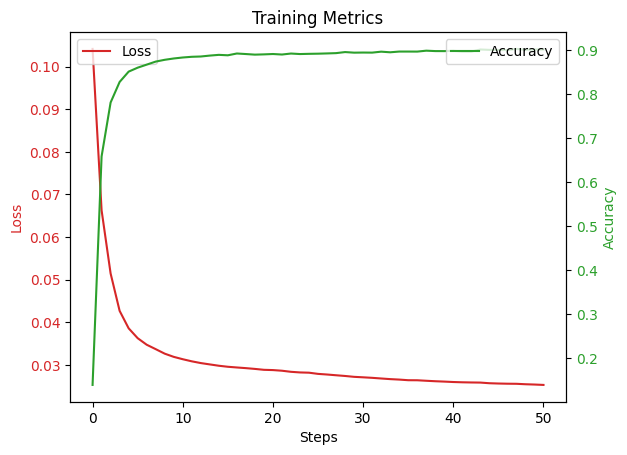

Actual number of parameters: 16175


In [3]:
input_size, output_size, X_train, y_train, X_test, y_test = mnist_utils.from_dataset(digits_train_32k_test_12k)


class ClassificationModel(nnx.Module):
    def __init__(self, rngs=nnx.Rngs(model_utils.SEED)):
        self.hidden_1 = LinearAndGeluBlock(input_size, model_utils.CLASSIFICATION_FEATURES[0], rngs=rngs)
        self.hidden_2 = LinearAndGeluBlock(model_utils.CLASSIFICATION_FEATURES[0],
                                           model_utils.CLASSIFICATION_FEATURES[1], rngs=rngs)
        self.output_layer = LinearAndGeluBlock(model_utils.CLASSIFICATION_FEATURES[1], output_size, rngs=rngs)

    def __call__(self, x):
        x = self.hidden_1(x)
        x = self.hidden_2(x)
        return self.output_layer(x)


classification_model = ClassificationModel()
classification_model_predict = lambda X: np.array(classification_model(X))

classification_optimizer_transformation = optax.chain(
    add_l1_regularization(lambda_l1=0.1 * model_utils.L1_DECAY),
    optax.add_decayed_weights(model_utils.L2_DECAY),
    optax.sgd(learning_rate=model_utils.LEARNING_RATE, momentum=model_utils.MOMENTUM,
              nesterov=model_utils.NESTEROV_MOMENTUM),
)
classification_optimizer = nnx.Optimizer(classification_model, classification_optimizer_transformation)

epoch_loss = [model_utils.mse_loss(classification_model_predict, X_test, y_test)]
epoch_accuracy = [model_utils.calculate_accuracy(classification_model_predict, X_test, y_test)]

for epoch in trange(model_utils.CLASSIFICATION_EPOCHS, desc="Training Progress"):
    for X_batch, y_batch in model_utils.create_batches(X_train, y_train, model_utils.BATCH_SIZE):
        train_step(classification_model, classification_optimizer, X_batch, y_batch)
    epoch_loss.append(model_utils.mse_loss(classification_model_predict, X_test, y_test))
    epoch_accuracy.append(model_utils.calculate_accuracy(classification_model_predict, X_test, y_test))

model_utils.plot_training_metrics(epoch_loss, epoch_accuracy)
print(f'Actual number of parameters: {count_parameters(classification_model)}')

Accuracy on training set: 0.9006388888888889
Accuracy on test set: 0.9020833333333333
Random test indices: [ 3427  9707  7158 10980  7015]


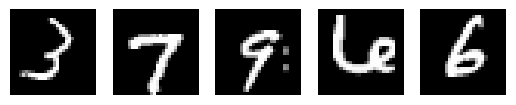

Actual labels of random test indices: [3 7 9 6 6]
Predicted labels of random test indices: [2 7 9 6 6]


array([['-0.01', '0.25', '0.25', '0.14', '0.02', '0.01', '0.01', '0.05',
        '0.07', '0.07'],
       ['-0.01', '-0.01', '-0.07', '-0.07', '-0.02', '-0.03', '-0.05',
        '1.28', '-0.0', '0.02'],
       ['-0.02', '0.01', '-0.05', '-0.02', '0.09', '0.13', '0.03',
        '0.15', '0.04', '0.66'],
       ['0.4', '0.0', '0.13', '-0.08', '0.03', '-0.14', '0.51', '0.13',
        '-0.08', '0.09'],
       ['-0.01', '-0.0', '0.01', '-0.03', '-0.04', '-0.01', '1.15',
        '-0.0', '0.03', '-0.04']], dtype='<U32')

In [4]:
_, _, X_train, y_train, X_test, y_test = mnist_utils.from_dataset(digits_train_32k_test_12k)

print(f'Accuracy on training set: {model_utils.calculate_accuracy(classification_model_predict, X_train, y_train)}')
print(f'Accuracy on test set: {model_utils.calculate_accuracy(classification_model_predict, X_test, y_test)}')

random_test_indices = np.random.choice(X_test.shape[0], 5, replace=False)
print(f'Random test indices: {random_test_indices}')

mnist_utils.plot_images(X_test[random_test_indices], image_size=image_size, cmap='gray')
print(f'Actual labels of random test indices: {np.argmax(y_test[random_test_indices], axis=1)}')

predicted = classification_model_predict(X_test[random_test_indices])
print(f'Predicted labels of random test indices: {np.argmax(predicted, axis=1)}')
predicted.round(2).astype('str')

## Dimensionality Reduction with an Autoencoder

This section demonstrates the use of two neural networks for dimensionality reduction. These networks rely on a bottleneck layer in their architecture to reduce the input data's dimensionality.

Instead of using predefined methods to extract the most relevant features, the networks are trained using backpropagation. This approach enables the model to automatically learn a transformation into a compressed feature space along with its inverse transformation to reconstruct the input data as accurately as possible.

### Autoencoder Network with 12 Neurons Bottleneck Layer

This model is configured as follows:

- **Architecture**:
  - Input layer: 784 neurons
  - 5 hidden layers:
    - Layer 1: 196 neurons
    - Layer 2: 49 neurons
    - Layer 3: 12 neurons
    - Layer 4: 49 neurons
    - Layer 5: 196 neurons
  - Output layer: 784 neurons
  - Total parameters: 328998 (Biases included)
- **Activation Function**: gelu
- **Optimizer**: Stochastic Gradient Descent (SGD)
  - Learning rate: 0.02 / 32 (=batch_size)
  - Momentum: 0.2 with Nesterov term
  - L2-weight-decay: 0.01 * 0.001 (bigger values break training)
  - L1-weight-decay: 0.01 * 0.001 (bigger values break training)
- **Loss Function**: Mean Squared Error (MSE)

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

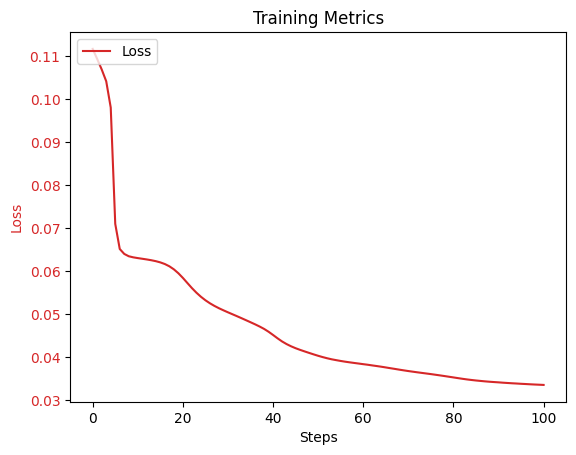

Actual number of parameters: 328998


In [5]:
input_size, _, X_train, _, X_test, _ = mnist_utils.from_dataset(digits_input_reconstruction)


class AutoencoderModel(nnx.Module):
    def __init__(self, rngs=nnx.Rngs(model_utils.SEED)):
        features = model_utils.AUTOENCODER_FEATURES
        self.hidden_1 = LinearAndGeluBlock(input_size, features[0], rngs=rngs)
        self.hidden_2 = LinearAndGeluBlock(features[0], features[1], rngs=rngs)
        self.hidden_3 = LinearAndGeluBlock(features[1], features[2], rngs=rngs)
        self.hidden_4 = LinearAndGeluBlock(features[2], features[3], rngs=rngs)
        self.hidden_5 = LinearAndGeluBlock(features[3], features[4], rngs=rngs)
        self.output_layer = LinearAndGeluBlock(features[4], input_size, rngs=rngs)

    def __call__(self, x):
        x = self.hidden_1(x)
        x = self.hidden_2(x)
        x = self.hidden_3(x)
        x = self.hidden_4(x)
        x = self.hidden_5(x)
        return self.output_layer(x)


autoencoder_model = AutoencoderModel()
autoencoder_model_predict = lambda X: np.array(autoencoder_model(X))

autoencoder_optimizer_transformation = optax.chain(
    add_l1_regularization(lambda_l1=0.01 * model_utils.L1_DECAY),
    optax.add_decayed_weights(0.01 * model_utils.L2_DECAY),
    optax.sgd(learning_rate=model_utils.LEARNING_RATE, momentum=model_utils.MOMENTUM,
              nesterov=model_utils.NESTEROV_MOMENTUM),
)
autoencoder_optimizer = nnx.Optimizer(autoencoder_model, autoencoder_optimizer_transformation)

epoch_loss = [model_utils.mse_loss(autoencoder_model_predict, X_test, X_test)]
for epoch in trange(model_utils.AUTOENCODER_EPOCHS, desc="Training Progress"):
    for X_batch, y_batch in model_utils.create_batches(X_train, X_train, model_utils.BATCH_SIZE):
        train_step(autoencoder_model, autoencoder_optimizer, X_batch, y_batch)
    epoch_loss.append(model_utils.mse_loss(autoencoder_model_predict, X_test, X_test))

model_utils.plot_training_metrics(epoch_loss)
print(f'Actual number of parameters: {count_parameters(autoencoder_model)}')

Loss X_train: 0.03347428888082504
Loss X_test: 0.033460572361946106
Random test indices: [ 8114  3547  1710 10395  5070]


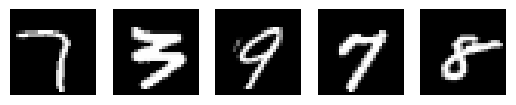

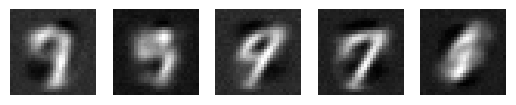

In [6]:
_, _, X_train, _, X_test, _ = mnist_utils.from_dataset(digits_input_reconstruction)

print(f'Loss X_train: {model_utils.mse_loss(autoencoder_model_predict, X_train, X_train)}')
print(f'Loss X_test: {model_utils.mse_loss(autoencoder_model_predict, X_test, X_test)}')

random_test_indices = np.random.choice(X_test.shape[0], 5, replace=False)
print(f'Random test indices: {random_test_indices}')

original = X_test[random_test_indices]
mnist_utils.plot_images(original, image_size=image_size, cmap='gray')

restored = autoencoder_model_predict(original)
mnist_utils.plot_images(restored, image_size=image_size, cmap='gray')